# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [15]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

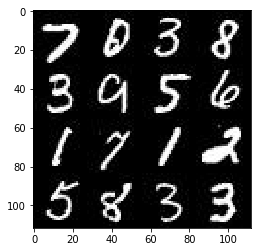

In [16]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

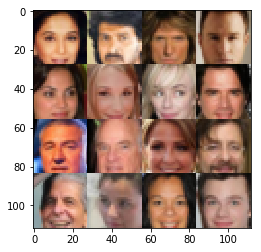

In [17]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [19]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Helpers

I wrote these to remove the deplicated code from all over the place and reduce copy-paste errors

In [20]:
def lrelu(tensor, alpha=0.2):
    """Calculate a leaky ReLU with the supplied tensor and alpha"""
    return tf.maximum(tensor, tensor * alpha)

In [21]:
def conv2d_leaky(inputs, outputs, kernel_size=5, strides=2, padding='same', alpha=0.2):
    layer = tf.layers.conv2d(inputs, outputs, kernel_size, strides, padding)
    return lrelu(layer, alpha) if alpha != -1 else layer

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [22]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    drop_rate = 0.1

    # image shape: batch_count, 28, 28, 3
    with tf.variable_scope('discriminator', reuse=reuse):
        
        conv0 = conv2d_leaky(images, 32, strides=1, padding='same')
        conv0 = tf.layers.dropout(conv0, drop_rate)
        
        conv1 = conv2d_leaky(images, 64, strides=2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=False)
        conv1 = tf.layers.dropout(conv1, drop_rate)
        # now 14x14x64

        conv2 = conv2d_leaky(conv1, 128)
        conv2 = tf.layers.batch_normalization(conv2, training=False)
        conv2 = tf.layers.dropout(conv2, drop_rate)
        # now 7x7x128
                
        conv3 = conv2d_leaky(conv2, 256, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=False)
        conv3 = tf.layers.dropout(conv3, drop_rate)
        # now 4x4x256
        
        conv4 = conv2d_leaky(conv3, 512, strides=1, padding='same')
        conv4 = tf.layers.batch_normalization(conv4, training=False)
        conv4 = tf.layers.dropout(conv4, drop_rate)
        
        
        flat = tf.reshape(conv4, (-1, 2 * 2 * 512))
        
        logits = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    drop_rate = 0.1
    alpha = 0.1

    with tf.variable_scope('generator', reuse=not is_train):

        x1 = tf.layers.dense(z, 28 * 28 * 64,
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                             bias_initializer=tf.contrib.layers.xavier_initializer())
        

        x1 = tf.reshape(x1, (-1, 28, 28, 64))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = lrelu(x1, alpha)

        
        x2 = tf.layers.conv2d_transpose(x1, 32, 5, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                        bias_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = lrelu(x2, alpha)
        x2 = tf.layers.dropout(x2, drop_rate, training=is_train)
        # 14x14x256 now


        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                            bias_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # encapsulate the repeated logic
    def model_loss(logits, like_shape_for_labels, smoothing=1):
        return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=like_shape_for_labels))
    
    smoothing = 0.9 # factor to help with generalization
    
    # now actually calculate those losses
    d_loss_real = model_loss(d_logits_real, tf.ones_like(d_model_real) * smoothing)

    d_loss_fake = model_loss(d_logits_fake, tf.zeros_like(d_model_fake))
    g_loss = model_loss(d_logits_fake, tf.ones_like(d_model_fake))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainables = tf.trainable_variables()
    d_vars = [var for var in trainables if var.name.startswith('discriminator')]
    g_vars = [var for var in trainables if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    print("parameters:")
    print("\t epoch_count =", epoch_count)
    print("\t batch_size =", batch_size)
    print("\t z_dim =", z_dim)
    print("\t learning_rate =", learning_rate)
    print("\t beta1 =", beta1)
    print("\t data_shape =", data_shape)
    print("\t image_mode =", data_image_mode)
    
    data_set_size, width, height, channels = data_shape
    
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0
    print_every = 20
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Optimizers do their thing
                _ = sess.run(d_opt, feed_dict={ input_z: batch_z, input_real: batch_images, lr: learning_rate })

                # double dip for the Generator, see if it addresses the symptoms
                for _ in range(0, 2):
                    _ = sess.run(g_opt, feed_dict={ input_z: batch_z, input_real: batch_images, lr: learning_rate })
                
                if step % print_every == 0:
                    train_loss_d = d_loss.eval({ input_z: batch_z, input_real: batch_images })
                    train_loss_g = g_loss.eval({ input_z: batch_z })

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step {}".format(step),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if step % show_every == 0:
                    show_generator_output(sess, 10, input_z, channels, data_image_mode)

        # No return value because we are just churning on the data
        print("Training Complete")
        show_generator_output(sess, 16, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

parameters:
	 epoch_count = 2
	 batch_size = 32
	 z_dim = 100
	 learning_rate = 0.0002
	 beta1 = 0.2
	 data_shape = (60000, 28, 28, 1)
	 image_mode = L
Epoch 1/2... Step 20 Discriminator Loss: 1.4264... Generator Loss: 0.7150
Epoch 1/2... Step 40 Discriminator Loss: 1.4409... Generator Loss: 0.6886
Epoch 1/2... Step 60 Discriminator Loss: 1.4145... Generator Loss: 0.7359
Epoch 1/2... Step 80 Discriminator Loss: 1.4070... Generator Loss: 0.7404
Epoch 1/2... Step 100 Discriminator Loss: 1.4298... Generator Loss: 0.7444


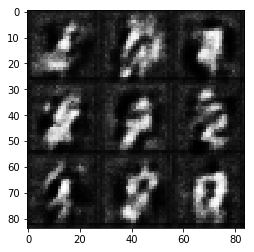

Epoch 1/2... Step 120 Discriminator Loss: 1.4558... Generator Loss: 0.6180
Epoch 1/2... Step 140 Discriminator Loss: 1.4514... Generator Loss: 0.6327
Epoch 1/2... Step 160 Discriminator Loss: 1.4952... Generator Loss: 0.6347
Epoch 1/2... Step 180 Discriminator Loss: 1.4171... Generator Loss: 0.7183
Epoch 1/2... Step 200 Discriminator Loss: 1.4685... Generator Loss: 0.7004


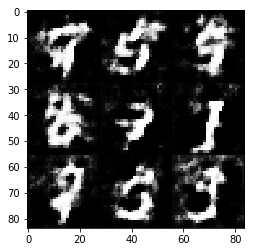

Epoch 1/2... Step 220 Discriminator Loss: 1.4826... Generator Loss: 0.7247
Epoch 1/2... Step 240 Discriminator Loss: 1.5272... Generator Loss: 0.5746
Epoch 1/2... Step 260 Discriminator Loss: 1.4876... Generator Loss: 0.6529
Epoch 1/2... Step 280 Discriminator Loss: 1.5306... Generator Loss: 0.4713
Epoch 1/2... Step 300 Discriminator Loss: 1.5070... Generator Loss: 0.7369


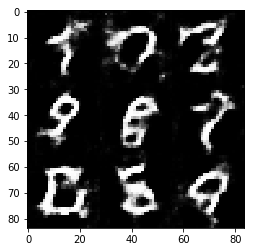

Epoch 1/2... Step 320 Discriminator Loss: 1.6045... Generator Loss: 0.4546
Epoch 1/2... Step 340 Discriminator Loss: 1.4868... Generator Loss: 0.6036
Epoch 1/2... Step 360 Discriminator Loss: 1.5225... Generator Loss: 0.6676
Epoch 1/2... Step 380 Discriminator Loss: 1.4249... Generator Loss: 0.6430
Epoch 1/2... Step 400 Discriminator Loss: 1.4716... Generator Loss: 0.7415


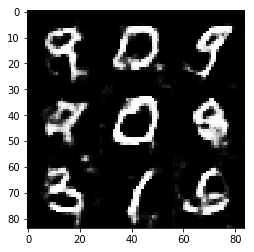

Epoch 1/2... Step 420 Discriminator Loss: 1.5020... Generator Loss: 0.5363
Epoch 1/2... Step 440 Discriminator Loss: 1.4145... Generator Loss: 0.7260
Epoch 1/2... Step 460 Discriminator Loss: 1.4646... Generator Loss: 0.6526
Epoch 1/2... Step 480 Discriminator Loss: 1.5216... Generator Loss: 0.6735
Epoch 1/2... Step 500 Discriminator Loss: 1.5315... Generator Loss: 0.4674


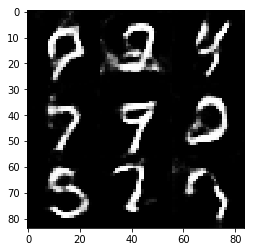

Epoch 1/2... Step 520 Discriminator Loss: 1.4645... Generator Loss: 0.6789
Epoch 1/2... Step 540 Discriminator Loss: 1.3577... Generator Loss: 0.7226
Epoch 1/2... Step 560 Discriminator Loss: 1.4542... Generator Loss: 0.6651
Epoch 1/2... Step 580 Discriminator Loss: 1.4842... Generator Loss: 0.6430
Epoch 1/2... Step 600 Discriminator Loss: 1.4014... Generator Loss: 0.7472


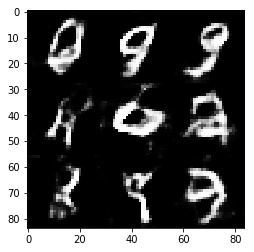

Epoch 1/2... Step 620 Discriminator Loss: 1.4309... Generator Loss: 0.6680
Epoch 1/2... Step 640 Discriminator Loss: 1.4513... Generator Loss: 0.6434
Epoch 1/2... Step 660 Discriminator Loss: 1.4212... Generator Loss: 1.0137
Epoch 1/2... Step 680 Discriminator Loss: 1.4173... Generator Loss: 0.6604
Epoch 1/2... Step 700 Discriminator Loss: 1.3957... Generator Loss: 0.6512


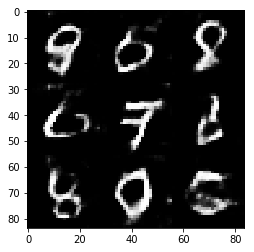

Epoch 1/2... Step 720 Discriminator Loss: 1.4441... Generator Loss: 0.7460
Epoch 1/2... Step 740 Discriminator Loss: 1.3395... Generator Loss: 0.6678
Epoch 1/2... Step 760 Discriminator Loss: 1.5085... Generator Loss: 0.4908
Epoch 1/2... Step 780 Discriminator Loss: 1.5349... Generator Loss: 0.5105
Epoch 1/2... Step 800 Discriminator Loss: 1.6038... Generator Loss: 0.3873


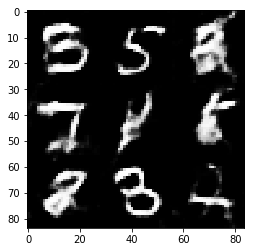

Epoch 1/2... Step 820 Discriminator Loss: 1.3482... Generator Loss: 0.7199
Epoch 1/2... Step 840 Discriminator Loss: 1.4359... Generator Loss: 0.6754
Epoch 1/2... Step 860 Discriminator Loss: 1.6103... Generator Loss: 0.4505
Epoch 1/2... Step 880 Discriminator Loss: 1.4541... Generator Loss: 0.5804
Epoch 1/2... Step 900 Discriminator Loss: 1.4651... Generator Loss: 0.5089


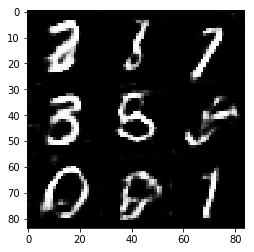

Epoch 1/2... Step 920 Discriminator Loss: 1.3644... Generator Loss: 0.6727
Epoch 1/2... Step 940 Discriminator Loss: 1.3178... Generator Loss: 0.9211
Epoch 1/2... Step 960 Discriminator Loss: 1.3646... Generator Loss: 0.7282
Epoch 1/2... Step 980 Discriminator Loss: 1.4739... Generator Loss: 0.5836
Epoch 1/2... Step 1000 Discriminator Loss: 1.3426... Generator Loss: 0.5932


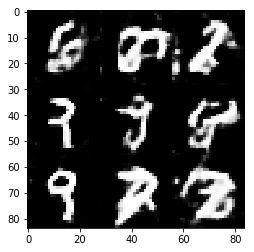

Epoch 1/2... Step 1020 Discriminator Loss: 1.2751... Generator Loss: 0.7237
Epoch 1/2... Step 1040 Discriminator Loss: 1.3388... Generator Loss: 0.7929
Epoch 1/2... Step 1060 Discriminator Loss: 1.2844... Generator Loss: 0.8215
Epoch 1/2... Step 1080 Discriminator Loss: 1.5529... Generator Loss: 0.4519
Epoch 1/2... Step 1100 Discriminator Loss: 1.3100... Generator Loss: 0.6670


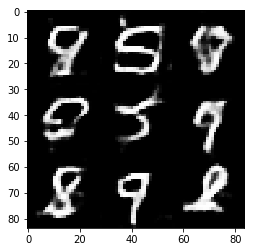

Epoch 1/2... Step 1120 Discriminator Loss: 1.3493... Generator Loss: 0.7118
Epoch 1/2... Step 1140 Discriminator Loss: 1.3428... Generator Loss: 0.6307
Epoch 1/2... Step 1160 Discriminator Loss: 1.7133... Generator Loss: 0.3331
Epoch 1/2... Step 1180 Discriminator Loss: 1.3572... Generator Loss: 0.7505
Epoch 1/2... Step 1200 Discriminator Loss: 1.3990... Generator Loss: 0.7114


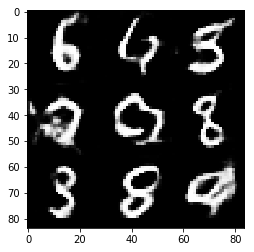

Epoch 1/2... Step 1220 Discriminator Loss: 1.2460... Generator Loss: 0.8740
Epoch 1/2... Step 1240 Discriminator Loss: 1.2159... Generator Loss: 0.9107
Epoch 1/2... Step 1260 Discriminator Loss: 1.3229... Generator Loss: 0.6709
Epoch 1/2... Step 1280 Discriminator Loss: 1.2049... Generator Loss: 1.1834
Epoch 1/2... Step 1300 Discriminator Loss: 1.2487... Generator Loss: 0.8921


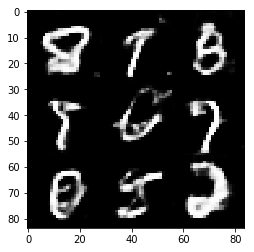

Epoch 1/2... Step 1320 Discriminator Loss: 1.4292... Generator Loss: 0.4979
Epoch 1/2... Step 1340 Discriminator Loss: 1.2843... Generator Loss: 0.7209
Epoch 1/2... Step 1360 Discriminator Loss: 1.4532... Generator Loss: 0.4961
Epoch 1/2... Step 1380 Discriminator Loss: 1.1868... Generator Loss: 1.0714
Epoch 1/2... Step 1400 Discriminator Loss: 1.3212... Generator Loss: 0.6662


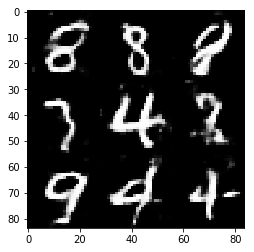

Epoch 1/2... Step 1420 Discriminator Loss: 1.4118... Generator Loss: 0.5915
Epoch 1/2... Step 1440 Discriminator Loss: 1.4402... Generator Loss: 0.6042
Epoch 1/2... Step 1460 Discriminator Loss: 1.2988... Generator Loss: 0.9142
Epoch 1/2... Step 1480 Discriminator Loss: 1.4754... Generator Loss: 0.5479
Epoch 1/2... Step 1500 Discriminator Loss: 1.4583... Generator Loss: 0.5336


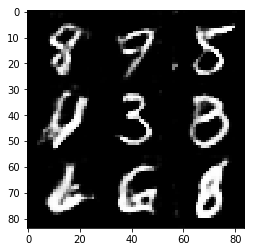

Epoch 1/2... Step 1520 Discriminator Loss: 1.3860... Generator Loss: 0.6157
Epoch 1/2... Step 1540 Discriminator Loss: 1.6827... Generator Loss: 0.4055
Epoch 1/2... Step 1560 Discriminator Loss: 1.0815... Generator Loss: 1.0659
Epoch 1/2... Step 1580 Discriminator Loss: 1.3130... Generator Loss: 0.6690
Epoch 1/2... Step 1600 Discriminator Loss: 1.3032... Generator Loss: 0.7217


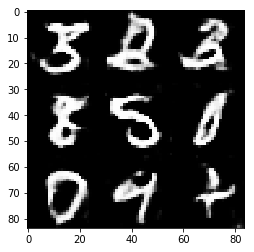

Epoch 1/2... Step 1620 Discriminator Loss: 1.1204... Generator Loss: 1.0707
Epoch 1/2... Step 1640 Discriminator Loss: 1.3390... Generator Loss: 0.7340
Epoch 1/2... Step 1660 Discriminator Loss: 1.2766... Generator Loss: 0.6931
Epoch 1/2... Step 1680 Discriminator Loss: 1.2603... Generator Loss: 0.9022
Epoch 1/2... Step 1700 Discriminator Loss: 1.2167... Generator Loss: 0.8699


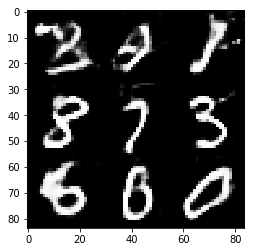

Epoch 1/2... Step 1720 Discriminator Loss: 1.3257... Generator Loss: 0.5916
Epoch 1/2... Step 1740 Discriminator Loss: 1.1002... Generator Loss: 1.0107
Epoch 1/2... Step 1760 Discriminator Loss: 1.3789... Generator Loss: 0.6894
Epoch 1/2... Step 1780 Discriminator Loss: 1.5412... Generator Loss: 0.5168
Epoch 1/2... Step 1800 Discriminator Loss: 1.4943... Generator Loss: 0.5000


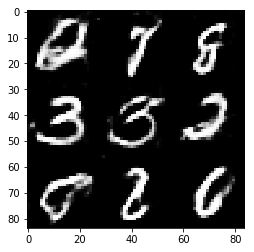

Epoch 1/2... Step 1820 Discriminator Loss: 1.1570... Generator Loss: 0.8780
Epoch 1/2... Step 1840 Discriminator Loss: 1.2710... Generator Loss: 0.7408
Epoch 1/2... Step 1860 Discriminator Loss: 1.2880... Generator Loss: 0.6991
Epoch 2/2... Step 1880 Discriminator Loss: 1.2867... Generator Loss: 0.6515
Epoch 2/2... Step 1900 Discriminator Loss: 1.2442... Generator Loss: 0.9108


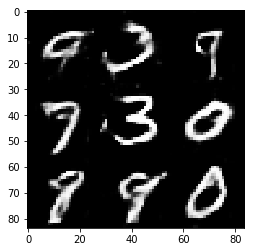

Epoch 2/2... Step 1920 Discriminator Loss: 1.0416... Generator Loss: 0.9902
Epoch 2/2... Step 1940 Discriminator Loss: 0.9491... Generator Loss: 1.0499
Epoch 2/2... Step 1960 Discriminator Loss: 1.1832... Generator Loss: 1.1139
Epoch 2/2... Step 1980 Discriminator Loss: 1.5291... Generator Loss: 0.4731
Epoch 2/2... Step 2000 Discriminator Loss: 1.3473... Generator Loss: 0.6223


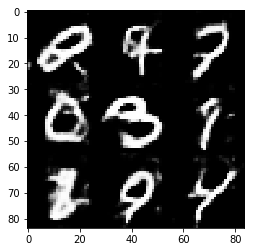

Epoch 2/2... Step 2020 Discriminator Loss: 1.1050... Generator Loss: 0.8210
Epoch 2/2... Step 2040 Discriminator Loss: 1.0417... Generator Loss: 1.0667
Epoch 2/2... Step 2060 Discriminator Loss: 1.1615... Generator Loss: 1.1925
Epoch 2/2... Step 2080 Discriminator Loss: 1.2610... Generator Loss: 0.9974
Epoch 2/2... Step 2100 Discriminator Loss: 1.2891... Generator Loss: 0.6732


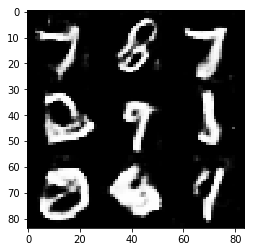

Epoch 2/2... Step 2120 Discriminator Loss: 1.2131... Generator Loss: 0.6856
Epoch 2/2... Step 2140 Discriminator Loss: 1.3141... Generator Loss: 0.6899
Epoch 2/2... Step 2160 Discriminator Loss: 1.0901... Generator Loss: 1.0502
Epoch 2/2... Step 2180 Discriminator Loss: 1.2354... Generator Loss: 0.6858
Epoch 2/2... Step 2200 Discriminator Loss: 1.1830... Generator Loss: 0.8073


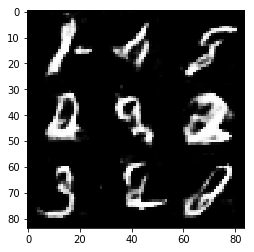

Epoch 2/2... Step 2220 Discriminator Loss: 1.1885... Generator Loss: 0.7792
Epoch 2/2... Step 2240 Discriminator Loss: 1.1600... Generator Loss: 0.8890
Epoch 2/2... Step 2260 Discriminator Loss: 1.2349... Generator Loss: 0.7232
Epoch 2/2... Step 2280 Discriminator Loss: 1.0728... Generator Loss: 1.0803
Epoch 2/2... Step 2300 Discriminator Loss: 1.5384... Generator Loss: 0.5347


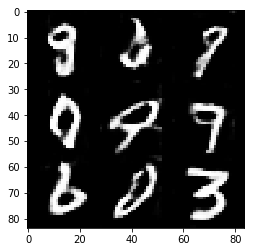

Epoch 2/2... Step 2320 Discriminator Loss: 1.1344... Generator Loss: 0.9331
Epoch 2/2... Step 2340 Discriminator Loss: 1.2604... Generator Loss: 0.7174
Epoch 2/2... Step 2360 Discriminator Loss: 1.2076... Generator Loss: 1.1061
Epoch 2/2... Step 2380 Discriminator Loss: 1.1369... Generator Loss: 0.9968
Epoch 2/2... Step 2400 Discriminator Loss: 1.6860... Generator Loss: 0.3802


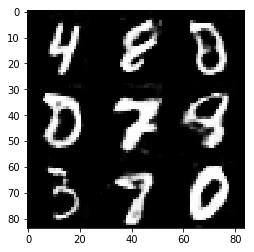

Epoch 2/2... Step 2420 Discriminator Loss: 1.2181... Generator Loss: 0.8169
Epoch 2/2... Step 2440 Discriminator Loss: 1.1529... Generator Loss: 0.8387
Epoch 2/2... Step 2460 Discriminator Loss: 1.2641... Generator Loss: 0.7507
Epoch 2/2... Step 2480 Discriminator Loss: 1.1619... Generator Loss: 0.7574
Epoch 2/2... Step 2500 Discriminator Loss: 1.1869... Generator Loss: 0.7939


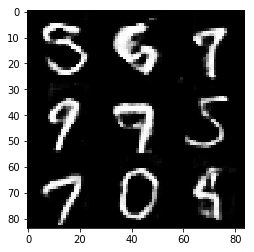

Epoch 2/2... Step 2520 Discriminator Loss: 1.1173... Generator Loss: 0.9530
Epoch 2/2... Step 2540 Discriminator Loss: 1.2242... Generator Loss: 1.2875
Epoch 2/2... Step 2560 Discriminator Loss: 1.1303... Generator Loss: 0.8949
Epoch 2/2... Step 2580 Discriminator Loss: 1.2143... Generator Loss: 0.6454
Epoch 2/2... Step 2600 Discriminator Loss: 2.1872... Generator Loss: 2.7075


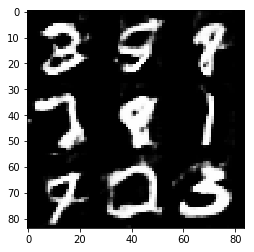

Epoch 2/2... Step 2620 Discriminator Loss: 1.0924... Generator Loss: 0.8037
Epoch 2/2... Step 2640 Discriminator Loss: 1.1268... Generator Loss: 0.9305
Epoch 2/2... Step 2660 Discriminator Loss: 1.2891... Generator Loss: 0.7010
Epoch 2/2... Step 2680 Discriminator Loss: 1.1003... Generator Loss: 1.0829
Epoch 2/2... Step 2700 Discriminator Loss: 1.1477... Generator Loss: 0.8400


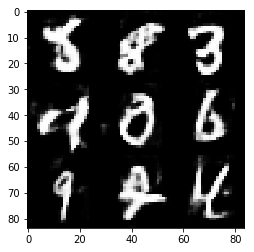

Epoch 2/2... Step 2720 Discriminator Loss: 1.4437... Generator Loss: 0.5361
Epoch 2/2... Step 2740 Discriminator Loss: 1.1845... Generator Loss: 0.8163
Epoch 2/2... Step 2760 Discriminator Loss: 1.0946... Generator Loss: 1.0411
Epoch 2/2... Step 2780 Discriminator Loss: 1.1644... Generator Loss: 0.8173
Epoch 2/2... Step 2800 Discriminator Loss: 1.1588... Generator Loss: 0.8499


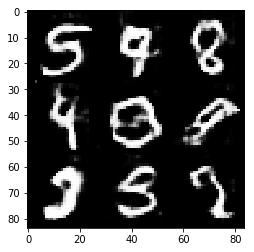

Epoch 2/2... Step 2820 Discriminator Loss: 1.0608... Generator Loss: 1.9622
Epoch 2/2... Step 2840 Discriminator Loss: 1.0337... Generator Loss: 1.1521
Epoch 2/2... Step 2860 Discriminator Loss: 1.1979... Generator Loss: 1.0598
Epoch 2/2... Step 2880 Discriminator Loss: 1.2547... Generator Loss: 0.6779
Epoch 2/2... Step 2900 Discriminator Loss: 1.1716... Generator Loss: 0.8525


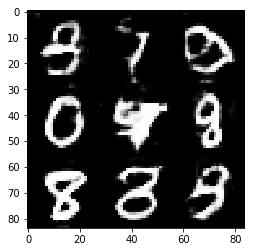

Epoch 2/2... Step 2920 Discriminator Loss: 1.2393... Generator Loss: 0.6918
Epoch 2/2... Step 2940 Discriminator Loss: 0.9963... Generator Loss: 0.9451
Epoch 2/2... Step 2960 Discriminator Loss: 1.0443... Generator Loss: 1.0283
Epoch 2/2... Step 2980 Discriminator Loss: 1.3671... Generator Loss: 0.5467
Epoch 2/2... Step 3000 Discriminator Loss: 1.1173... Generator Loss: 0.9674


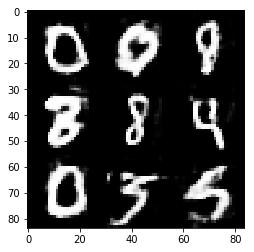

Epoch 2/2... Step 3020 Discriminator Loss: 1.1337... Generator Loss: 0.9435
Epoch 2/2... Step 3040 Discriminator Loss: 1.1600... Generator Loss: 0.7587
Epoch 2/2... Step 3060 Discriminator Loss: 0.9308... Generator Loss: 1.1763
Epoch 2/2... Step 3080 Discriminator Loss: 1.0958... Generator Loss: 0.9992
Epoch 2/2... Step 3100 Discriminator Loss: 1.1570... Generator Loss: 1.0613


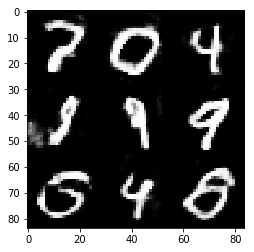

Epoch 2/2... Step 3120 Discriminator Loss: 0.9992... Generator Loss: 1.0301
Epoch 2/2... Step 3140 Discriminator Loss: 1.1473... Generator Loss: 0.7738
Epoch 2/2... Step 3160 Discriminator Loss: 1.0348... Generator Loss: 1.1784
Epoch 2/2... Step 3180 Discriminator Loss: 1.0087... Generator Loss: 1.4689
Epoch 2/2... Step 3200 Discriminator Loss: 1.1866... Generator Loss: 0.9750


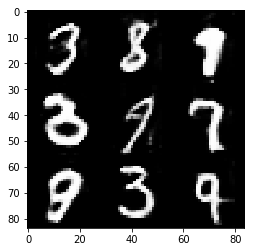

Epoch 2/2... Step 3220 Discriminator Loss: 1.1718... Generator Loss: 1.1298
Epoch 2/2... Step 3240 Discriminator Loss: 1.1875... Generator Loss: 0.9053
Epoch 2/2... Step 3260 Discriminator Loss: 1.0482... Generator Loss: 1.1556
Epoch 2/2... Step 3280 Discriminator Loss: 1.0413... Generator Loss: 1.1229
Epoch 2/2... Step 3300 Discriminator Loss: 0.9715... Generator Loss: 1.0594


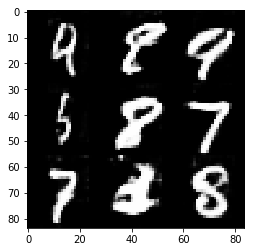

Epoch 2/2... Step 3320 Discriminator Loss: 1.0663... Generator Loss: 1.0013
Epoch 2/2... Step 3340 Discriminator Loss: 1.1706... Generator Loss: 1.4256
Epoch 2/2... Step 3360 Discriminator Loss: 1.3093... Generator Loss: 0.5856
Epoch 2/2... Step 3380 Discriminator Loss: 0.9681... Generator Loss: 1.0976
Epoch 2/2... Step 3400 Discriminator Loss: 1.0947... Generator Loss: 0.7984


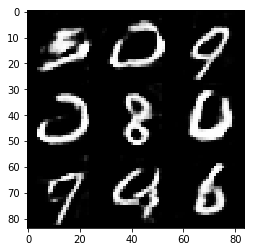

Epoch 2/2... Step 3420 Discriminator Loss: 1.0244... Generator Loss: 1.0062
Epoch 2/2... Step 3440 Discriminator Loss: 1.3069... Generator Loss: 0.5969
Epoch 2/2... Step 3460 Discriminator Loss: 1.0183... Generator Loss: 1.0031
Epoch 2/2... Step 3480 Discriminator Loss: 0.9753... Generator Loss: 1.0562
Epoch 2/2... Step 3500 Discriminator Loss: 1.0813... Generator Loss: 0.8710


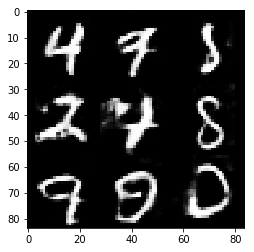

Epoch 2/2... Step 3520 Discriminator Loss: 1.0333... Generator Loss: 1.2212
Epoch 2/2... Step 3540 Discriminator Loss: 0.9472... Generator Loss: 1.5172
Epoch 2/2... Step 3560 Discriminator Loss: 1.1147... Generator Loss: 0.8051
Epoch 2/2... Step 3580 Discriminator Loss: 1.0322... Generator Loss: 1.0122
Epoch 2/2... Step 3600 Discriminator Loss: 0.8750... Generator Loss: 1.1954


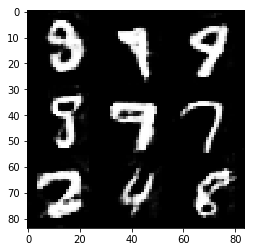

Epoch 2/2... Step 3620 Discriminator Loss: 1.0210... Generator Loss: 1.2446
Epoch 2/2... Step 3640 Discriminator Loss: 0.9929... Generator Loss: 0.9940
Epoch 2/2... Step 3660 Discriminator Loss: 1.0097... Generator Loss: 1.0184
Epoch 2/2... Step 3680 Discriminator Loss: 1.1086... Generator Loss: 0.7956
Epoch 2/2... Step 3700 Discriminator Loss: 1.3856... Generator Loss: 0.5290


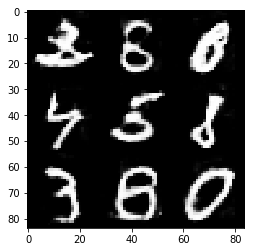

Epoch 2/2... Step 3720 Discriminator Loss: 1.4663... Generator Loss: 0.5795
Epoch 2/2... Step 3740 Discriminator Loss: 1.0048... Generator Loss: 1.0920
Training Complete


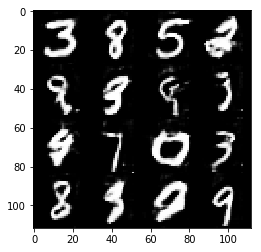

In [30]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

parameters:
	 epoch_count = 1
	 batch_size = 32
	 z_dim = 100
	 learning_rate = 0.0002
	 beta1 = 0.25
	 data_shape = (202599, 28, 28, 3)
	 image_mode = RGB
Epoch 1/1... Step 20 Discriminator Loss: 1.4461... Generator Loss: 0.7050
Epoch 1/1... Step 40 Discriminator Loss: 1.2343... Generator Loss: 1.0541
Epoch 1/1... Step 60 Discriminator Loss: 2.0376... Generator Loss: 0.2285
Epoch 1/1... Step 80 Discriminator Loss: 1.2256... Generator Loss: 0.8420
Epoch 1/1... Step 100 Discriminator Loss: 1.3643... Generator Loss: 0.7264


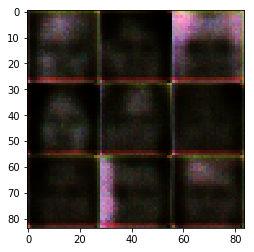

Epoch 1/1... Step 120 Discriminator Loss: 1.2754... Generator Loss: 0.8262
Epoch 1/1... Step 140 Discriminator Loss: 1.3410... Generator Loss: 1.2846
Epoch 1/1... Step 160 Discriminator Loss: 1.5868... Generator Loss: 0.5919
Epoch 1/1... Step 180 Discriminator Loss: 1.2077... Generator Loss: 1.2118
Epoch 1/1... Step 200 Discriminator Loss: 1.2896... Generator Loss: 0.7399


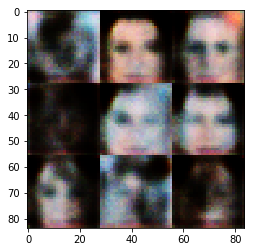

Epoch 1/1... Step 220 Discriminator Loss: 1.3049... Generator Loss: 0.8065
Epoch 1/1... Step 240 Discriminator Loss: 1.3440... Generator Loss: 0.7689
Epoch 1/1... Step 260 Discriminator Loss: 1.4124... Generator Loss: 0.7062
Epoch 1/1... Step 280 Discriminator Loss: 1.4005... Generator Loss: 0.6395
Epoch 1/1... Step 300 Discriminator Loss: 1.3905... Generator Loss: 0.6569


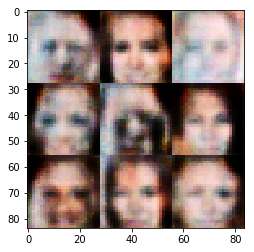

Epoch 1/1... Step 320 Discriminator Loss: 1.1404... Generator Loss: 0.9978
Epoch 1/1... Step 340 Discriminator Loss: 1.2630... Generator Loss: 0.7584
Epoch 1/1... Step 360 Discriminator Loss: 1.3610... Generator Loss: 0.6793
Epoch 1/1... Step 380 Discriminator Loss: 1.2319... Generator Loss: 1.0678
Epoch 1/1... Step 400 Discriminator Loss: 1.6689... Generator Loss: 0.4246


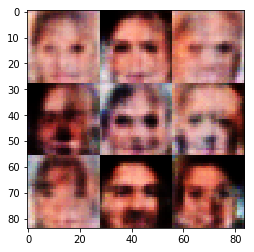

Epoch 1/1... Step 420 Discriminator Loss: 1.4969... Generator Loss: 0.5550
Epoch 1/1... Step 440 Discriminator Loss: 1.4533... Generator Loss: 0.5689
Epoch 1/1... Step 460 Discriminator Loss: 1.5457... Generator Loss: 1.3126
Epoch 1/1... Step 480 Discriminator Loss: 1.3823... Generator Loss: 0.7300
Epoch 1/1... Step 500 Discriminator Loss: 1.4918... Generator Loss: 0.7533


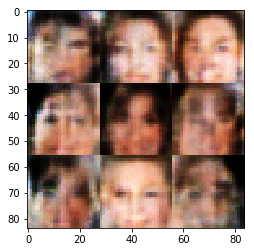

Epoch 1/1... Step 520 Discriminator Loss: 1.4956... Generator Loss: 0.5729
Epoch 1/1... Step 540 Discriminator Loss: 1.4109... Generator Loss: 0.7733
Epoch 1/1... Step 560 Discriminator Loss: 1.4718... Generator Loss: 0.6001
Epoch 1/1... Step 580 Discriminator Loss: 1.4663... Generator Loss: 1.1091
Epoch 1/1... Step 600 Discriminator Loss: 1.3618... Generator Loss: 0.6939


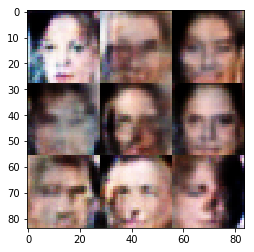

Epoch 1/1... Step 620 Discriminator Loss: 1.3750... Generator Loss: 0.7204
Epoch 1/1... Step 640 Discriminator Loss: 1.4133... Generator Loss: 0.6181
Epoch 1/1... Step 660 Discriminator Loss: 1.4162... Generator Loss: 0.6456
Epoch 1/1... Step 680 Discriminator Loss: 1.4512... Generator Loss: 0.6107
Epoch 1/1... Step 700 Discriminator Loss: 1.4182... Generator Loss: 0.8015


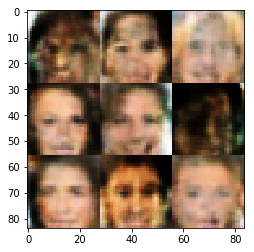

Epoch 1/1... Step 720 Discriminator Loss: 1.3592... Generator Loss: 0.8446
Epoch 1/1... Step 740 Discriminator Loss: 1.3766... Generator Loss: 0.8483
Epoch 1/1... Step 760 Discriminator Loss: 1.3595... Generator Loss: 0.8672
Epoch 1/1... Step 780 Discriminator Loss: 1.4099... Generator Loss: 0.6516
Epoch 1/1... Step 800 Discriminator Loss: 1.5105... Generator Loss: 0.7836


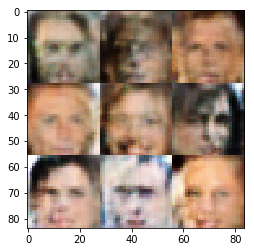

Epoch 1/1... Step 820 Discriminator Loss: 1.4390... Generator Loss: 0.7175
Epoch 1/1... Step 840 Discriminator Loss: 1.3743... Generator Loss: 0.7587
Epoch 1/1... Step 860 Discriminator Loss: 1.4130... Generator Loss: 0.7779
Epoch 1/1... Step 880 Discriminator Loss: 1.4026... Generator Loss: 0.7711
Epoch 1/1... Step 900 Discriminator Loss: 1.3779... Generator Loss: 0.8808


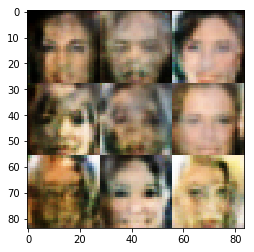

Epoch 1/1... Step 920 Discriminator Loss: 1.4232... Generator Loss: 0.7669
Epoch 1/1... Step 940 Discriminator Loss: 1.3884... Generator Loss: 0.7477
Epoch 1/1... Step 960 Discriminator Loss: 1.4184... Generator Loss: 0.7925
Epoch 1/1... Step 980 Discriminator Loss: 1.4167... Generator Loss: 0.7018
Epoch 1/1... Step 1000 Discriminator Loss: 1.4444... Generator Loss: 0.6926


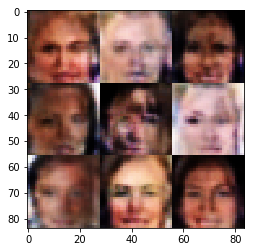

Epoch 1/1... Step 1020 Discriminator Loss: 1.3962... Generator Loss: 0.7402
Epoch 1/1... Step 1040 Discriminator Loss: 1.4326... Generator Loss: 0.7302
Epoch 1/1... Step 1060 Discriminator Loss: 1.3990... Generator Loss: 0.7495
Epoch 1/1... Step 1080 Discriminator Loss: 1.3972... Generator Loss: 0.7251
Epoch 1/1... Step 1100 Discriminator Loss: 1.4108... Generator Loss: 0.7296


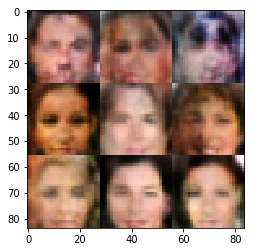

Epoch 1/1... Step 1120 Discriminator Loss: 1.4166... Generator Loss: 0.7812
Epoch 1/1... Step 1140 Discriminator Loss: 1.3811... Generator Loss: 0.8193
Epoch 1/1... Step 1160 Discriminator Loss: 1.4069... Generator Loss: 0.6939
Epoch 1/1... Step 1180 Discriminator Loss: 1.4178... Generator Loss: 0.7422
Epoch 1/1... Step 1200 Discriminator Loss: 1.3852... Generator Loss: 0.7652


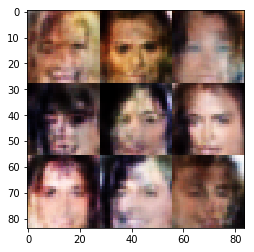

Epoch 1/1... Step 1220 Discriminator Loss: 1.4036... Generator Loss: 0.7461
Epoch 1/1... Step 1240 Discriminator Loss: 1.4132... Generator Loss: 0.7223
Epoch 1/1... Step 1260 Discriminator Loss: 1.4214... Generator Loss: 0.7333
Epoch 1/1... Step 1280 Discriminator Loss: 1.3845... Generator Loss: 0.7791
Epoch 1/1... Step 1300 Discriminator Loss: 1.4349... Generator Loss: 0.6796


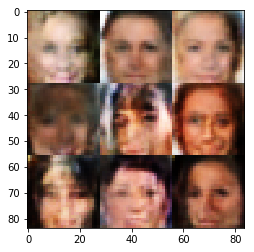

Epoch 1/1... Step 1320 Discriminator Loss: 1.4214... Generator Loss: 0.7485
Epoch 1/1... Step 1340 Discriminator Loss: 1.4373... Generator Loss: 0.7583
Epoch 1/1... Step 1360 Discriminator Loss: 1.4252... Generator Loss: 0.7547
Epoch 1/1... Step 1380 Discriminator Loss: 1.4259... Generator Loss: 0.7256
Epoch 1/1... Step 1400 Discriminator Loss: 1.4210... Generator Loss: 0.7502


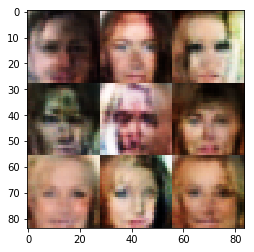

Epoch 1/1... Step 1420 Discriminator Loss: 1.4497... Generator Loss: 0.6867
Epoch 1/1... Step 1440 Discriminator Loss: 1.4087... Generator Loss: 0.7566
Epoch 1/1... Step 1460 Discriminator Loss: 1.4468... Generator Loss: 0.6515
Epoch 1/1... Step 1480 Discriminator Loss: 1.3954... Generator Loss: 0.7339
Epoch 1/1... Step 1500 Discriminator Loss: 1.4621... Generator Loss: 0.7119


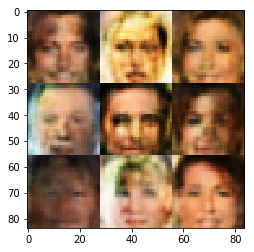

Epoch 1/1... Step 1520 Discriminator Loss: 1.4093... Generator Loss: 0.7390
Epoch 1/1... Step 1540 Discriminator Loss: 1.4072... Generator Loss: 0.7470
Epoch 1/1... Step 1560 Discriminator Loss: 1.4000... Generator Loss: 0.7558
Epoch 1/1... Step 1580 Discriminator Loss: 1.4580... Generator Loss: 0.6941
Epoch 1/1... Step 1600 Discriminator Loss: 1.4444... Generator Loss: 0.6634


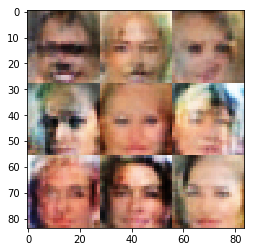

Epoch 1/1... Step 1620 Discriminator Loss: 1.4103... Generator Loss: 0.7701
Epoch 1/1... Step 1640 Discriminator Loss: 1.4012... Generator Loss: 0.7302
Epoch 1/1... Step 1660 Discriminator Loss: 1.4069... Generator Loss: 0.7497
Epoch 1/1... Step 1680 Discriminator Loss: 1.4880... Generator Loss: 0.6718
Epoch 1/1... Step 1700 Discriminator Loss: 1.4152... Generator Loss: 0.7486


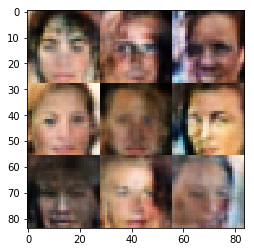

Epoch 1/1... Step 1720 Discriminator Loss: 1.4158... Generator Loss: 0.6833
Epoch 1/1... Step 1740 Discriminator Loss: 1.4377... Generator Loss: 0.7308
Epoch 1/1... Step 1760 Discriminator Loss: 1.4629... Generator Loss: 0.7259
Epoch 1/1... Step 1780 Discriminator Loss: 1.4616... Generator Loss: 0.6883
Epoch 1/1... Step 1800 Discriminator Loss: 1.4316... Generator Loss: 0.7034


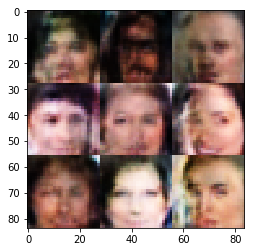

Epoch 1/1... Step 1820 Discriminator Loss: 1.4914... Generator Loss: 0.6345
Epoch 1/1... Step 1840 Discriminator Loss: 1.4411... Generator Loss: 0.7200
Epoch 1/1... Step 1860 Discriminator Loss: 1.4595... Generator Loss: 0.7455
Epoch 1/1... Step 1880 Discriminator Loss: 1.6599... Generator Loss: 0.5284
Epoch 1/1... Step 1900 Discriminator Loss: 1.3821... Generator Loss: 0.7449


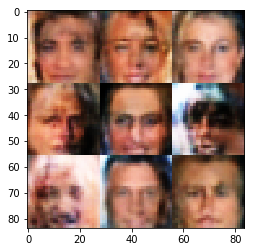

Epoch 1/1... Step 1920 Discriminator Loss: 1.4089... Generator Loss: 0.7597
Epoch 1/1... Step 1940 Discriminator Loss: 1.5393... Generator Loss: 0.6512
Epoch 1/1... Step 1960 Discriminator Loss: 1.4353... Generator Loss: 0.7202
Epoch 1/1... Step 1980 Discriminator Loss: 1.4126... Generator Loss: 0.7722
Epoch 1/1... Step 2000 Discriminator Loss: 1.4020... Generator Loss: 0.7894


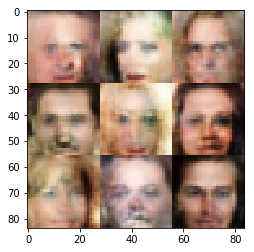

Epoch 1/1... Step 2020 Discriminator Loss: 1.4764... Generator Loss: 0.6764
Epoch 1/1... Step 2040 Discriminator Loss: 1.4858... Generator Loss: 0.6364
Epoch 1/1... Step 2060 Discriminator Loss: 1.4857... Generator Loss: 0.6888
Epoch 1/1... Step 2080 Discriminator Loss: 1.4359... Generator Loss: 0.6872
Epoch 1/1... Step 2100 Discriminator Loss: 1.4158... Generator Loss: 0.8001


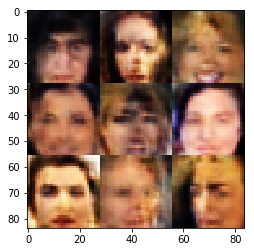

Epoch 1/1... Step 2120 Discriminator Loss: 1.4837... Generator Loss: 0.7410
Epoch 1/1... Step 2140 Discriminator Loss: 1.4356... Generator Loss: 0.7129
Epoch 1/1... Step 2160 Discriminator Loss: 1.4112... Generator Loss: 0.7105
Epoch 1/1... Step 2180 Discriminator Loss: 1.4901... Generator Loss: 0.7175
Epoch 1/1... Step 2200 Discriminator Loss: 1.4285... Generator Loss: 0.6864


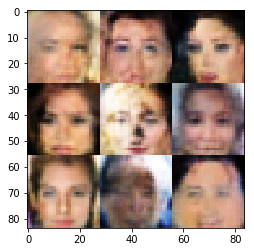

Epoch 1/1... Step 2220 Discriminator Loss: 1.4509... Generator Loss: 0.7283
Epoch 1/1... Step 2240 Discriminator Loss: 1.5220... Generator Loss: 0.6170
Epoch 1/1... Step 2260 Discriminator Loss: 1.4263... Generator Loss: 0.7118
Epoch 1/1... Step 2280 Discriminator Loss: 1.4622... Generator Loss: 0.7081
Epoch 1/1... Step 2300 Discriminator Loss: 1.5014... Generator Loss: 0.6551


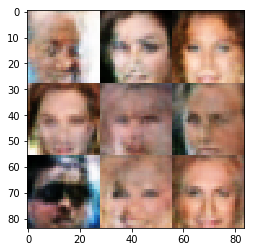

Epoch 1/1... Step 2320 Discriminator Loss: 1.5198... Generator Loss: 0.6439
Epoch 1/1... Step 2340 Discriminator Loss: 1.4988... Generator Loss: 0.6629
Epoch 1/1... Step 2360 Discriminator Loss: 1.4721... Generator Loss: 0.6969
Epoch 1/1... Step 2380 Discriminator Loss: 1.4567... Generator Loss: 0.7124
Epoch 1/1... Step 2400 Discriminator Loss: 1.4352... Generator Loss: 0.6999


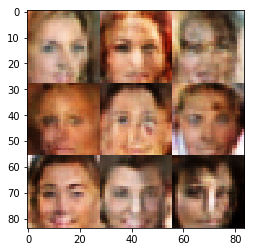

Epoch 1/1... Step 2420 Discriminator Loss: 1.4314... Generator Loss: 0.7359
Epoch 1/1... Step 2440 Discriminator Loss: 1.4845... Generator Loss: 0.7589
Epoch 1/1... Step 2460 Discriminator Loss: 1.4234... Generator Loss: 0.6770
Epoch 1/1... Step 2480 Discriminator Loss: 1.5748... Generator Loss: 0.6823
Epoch 1/1... Step 2500 Discriminator Loss: 1.3794... Generator Loss: 0.7558


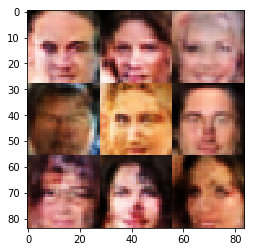

Epoch 1/1... Step 2520 Discriminator Loss: 1.4818... Generator Loss: 0.7199
Epoch 1/1... Step 2540 Discriminator Loss: 1.4484... Generator Loss: 0.7847
Epoch 1/1... Step 2560 Discriminator Loss: 1.3939... Generator Loss: 0.7432
Epoch 1/1... Step 2580 Discriminator Loss: 1.4860... Generator Loss: 0.7015
Epoch 1/1... Step 2600 Discriminator Loss: 1.5136... Generator Loss: 0.6740


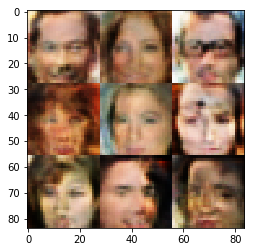

Epoch 1/1... Step 2620 Discriminator Loss: 1.5083... Generator Loss: 0.7176
Epoch 1/1... Step 2640 Discriminator Loss: 1.5158... Generator Loss: 0.6531
Epoch 1/1... Step 2660 Discriminator Loss: 1.4246... Generator Loss: 0.7346
Epoch 1/1... Step 2680 Discriminator Loss: 1.4737... Generator Loss: 0.7035
Epoch 1/1... Step 2700 Discriminator Loss: 1.4834... Generator Loss: 0.6255


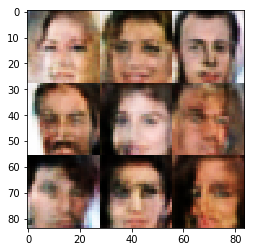

Epoch 1/1... Step 2720 Discriminator Loss: 1.4404... Generator Loss: 0.7508
Epoch 1/1... Step 2740 Discriminator Loss: 1.4358... Generator Loss: 0.7461
Epoch 1/1... Step 2760 Discriminator Loss: 1.4726... Generator Loss: 0.6678
Epoch 1/1... Step 2780 Discriminator Loss: 1.4458... Generator Loss: 0.7128
Epoch 1/1... Step 2800 Discriminator Loss: 1.4778... Generator Loss: 0.6934


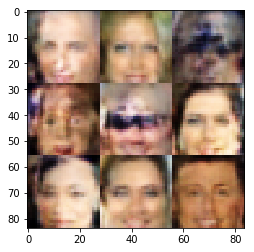

Epoch 1/1... Step 2820 Discriminator Loss: 1.4134... Generator Loss: 0.7369
Epoch 1/1... Step 2840 Discriminator Loss: 1.4870... Generator Loss: 0.6391
Epoch 1/1... Step 2860 Discriminator Loss: 1.4278... Generator Loss: 0.6859
Epoch 1/1... Step 2880 Discriminator Loss: 1.4800... Generator Loss: 0.6629
Epoch 1/1... Step 2900 Discriminator Loss: 1.5480... Generator Loss: 0.6396


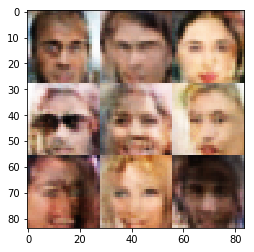

Epoch 1/1... Step 2920 Discriminator Loss: 1.4344... Generator Loss: 0.7501
Epoch 1/1... Step 2940 Discriminator Loss: 1.5478... Generator Loss: 0.6218
Epoch 1/1... Step 2960 Discriminator Loss: 1.4114... Generator Loss: 0.7000
Epoch 1/1... Step 2980 Discriminator Loss: 1.4160... Generator Loss: 0.7222
Epoch 1/1... Step 3000 Discriminator Loss: 1.5330... Generator Loss: 0.6579


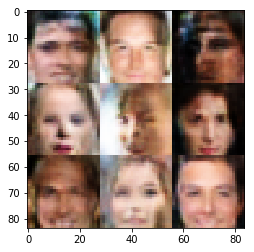

Epoch 1/1... Step 3020 Discriminator Loss: 1.5419... Generator Loss: 0.6676
Epoch 1/1... Step 3040 Discriminator Loss: 1.4557... Generator Loss: 0.6947
Epoch 1/1... Step 3060 Discriminator Loss: 1.4129... Generator Loss: 0.7380
Epoch 1/1... Step 3080 Discriminator Loss: 1.4264... Generator Loss: 0.7503
Epoch 1/1... Step 3100 Discriminator Loss: 1.5097... Generator Loss: 0.6918


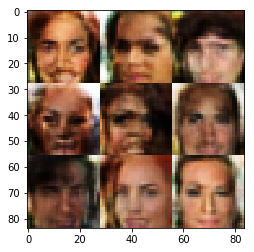

Epoch 1/1... Step 3120 Discriminator Loss: 1.5213... Generator Loss: 0.6341
Epoch 1/1... Step 3140 Discriminator Loss: 1.4323... Generator Loss: 0.7705
Epoch 1/1... Step 3160 Discriminator Loss: 1.5355... Generator Loss: 0.6105
Epoch 1/1... Step 3180 Discriminator Loss: 1.4326... Generator Loss: 0.7493
Epoch 1/1... Step 3200 Discriminator Loss: 1.4511... Generator Loss: 0.6964


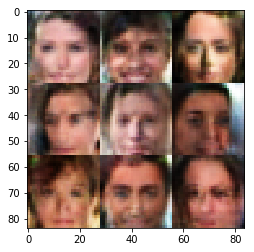

Epoch 1/1... Step 3220 Discriminator Loss: 1.5074... Generator Loss: 0.6641
Epoch 1/1... Step 3240 Discriminator Loss: 1.4705... Generator Loss: 0.7086
Epoch 1/1... Step 3260 Discriminator Loss: 1.4758... Generator Loss: 0.6838
Epoch 1/1... Step 3280 Discriminator Loss: 1.3941... Generator Loss: 0.7426
Epoch 1/1... Step 3300 Discriminator Loss: 1.5057... Generator Loss: 0.6951


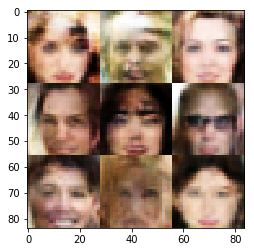

Epoch 1/1... Step 3320 Discriminator Loss: 1.6258... Generator Loss: 0.5419
Epoch 1/1... Step 3340 Discriminator Loss: 1.4856... Generator Loss: 0.6685
Epoch 1/1... Step 3360 Discriminator Loss: 1.4805... Generator Loss: 0.7032
Epoch 1/1... Step 3380 Discriminator Loss: 1.5118... Generator Loss: 0.6690
Epoch 1/1... Step 3400 Discriminator Loss: 1.4656... Generator Loss: 0.7206


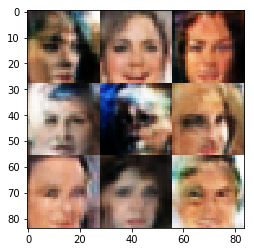

Epoch 1/1... Step 3420 Discriminator Loss: 1.4836... Generator Loss: 0.7262
Epoch 1/1... Step 3440 Discriminator Loss: 1.5225... Generator Loss: 0.7171
Epoch 1/1... Step 3460 Discriminator Loss: 1.4990... Generator Loss: 0.6946
Epoch 1/1... Step 3480 Discriminator Loss: 1.4368... Generator Loss: 0.7338
Epoch 1/1... Step 3500 Discriminator Loss: 1.3875... Generator Loss: 0.7352


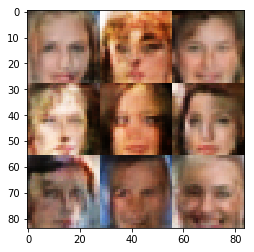

Epoch 1/1... Step 3520 Discriminator Loss: 1.5352... Generator Loss: 0.6901
Epoch 1/1... Step 3540 Discriminator Loss: 1.5073... Generator Loss: 0.6299
Epoch 1/1... Step 3560 Discriminator Loss: 1.5442... Generator Loss: 0.6403
Epoch 1/1... Step 3580 Discriminator Loss: 1.5162... Generator Loss: 0.6622
Epoch 1/1... Step 3600 Discriminator Loss: 1.4161... Generator Loss: 0.7365


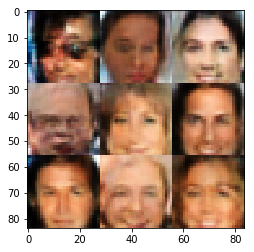

Epoch 1/1... Step 3620 Discriminator Loss: 1.6162... Generator Loss: 0.5905
Epoch 1/1... Step 3640 Discriminator Loss: 1.4484... Generator Loss: 0.6952
Epoch 1/1... Step 3660 Discriminator Loss: 1.5326... Generator Loss: 0.7301
Epoch 1/1... Step 3680 Discriminator Loss: 1.4612... Generator Loss: 0.6845
Epoch 1/1... Step 3700 Discriminator Loss: 1.4615... Generator Loss: 0.7018


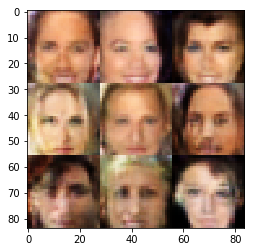

Epoch 1/1... Step 3720 Discriminator Loss: 1.4231... Generator Loss: 0.7053
Epoch 1/1... Step 3740 Discriminator Loss: 1.4598... Generator Loss: 0.7103
Epoch 1/1... Step 3760 Discriminator Loss: 1.4578... Generator Loss: 0.7109
Epoch 1/1... Step 3780 Discriminator Loss: 1.4707... Generator Loss: 0.7264
Epoch 1/1... Step 3800 Discriminator Loss: 1.5239... Generator Loss: 0.7025


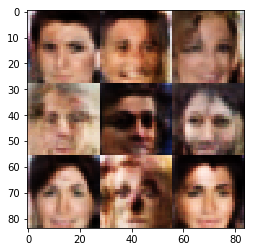

Epoch 1/1... Step 3820 Discriminator Loss: 1.5641... Generator Loss: 0.7203
Epoch 1/1... Step 3840 Discriminator Loss: 1.4512... Generator Loss: 0.7988
Epoch 1/1... Step 3860 Discriminator Loss: 1.4158... Generator Loss: 0.7605
Epoch 1/1... Step 3880 Discriminator Loss: 1.4565... Generator Loss: 0.6753
Epoch 1/1... Step 3900 Discriminator Loss: 1.4897... Generator Loss: 0.7158


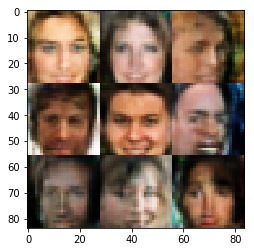

Epoch 1/1... Step 3920 Discriminator Loss: 1.3766... Generator Loss: 0.7414
Epoch 1/1... Step 3940 Discriminator Loss: 1.5207... Generator Loss: 0.5971
Epoch 1/1... Step 3960 Discriminator Loss: 1.4734... Generator Loss: 0.6770
Epoch 1/1... Step 3980 Discriminator Loss: 1.4688... Generator Loss: 0.6974
Epoch 1/1... Step 4000 Discriminator Loss: 1.4999... Generator Loss: 0.6700


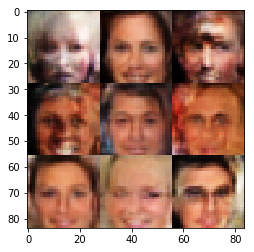

Epoch 1/1... Step 4020 Discriminator Loss: 1.4368... Generator Loss: 0.7285
Epoch 1/1... Step 4040 Discriminator Loss: 1.4476... Generator Loss: 0.7618
Epoch 1/1... Step 4060 Discriminator Loss: 1.4920... Generator Loss: 0.6842
Epoch 1/1... Step 4080 Discriminator Loss: 1.5200... Generator Loss: 0.6781
Epoch 1/1... Step 4100 Discriminator Loss: 1.4366... Generator Loss: 0.6842


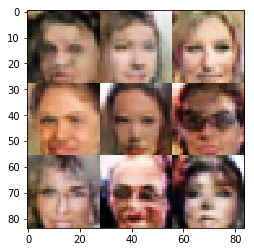

Epoch 1/1... Step 4120 Discriminator Loss: 1.4464... Generator Loss: 0.6822
Epoch 1/1... Step 4140 Discriminator Loss: 1.4827... Generator Loss: 0.6711
Epoch 1/1... Step 4160 Discriminator Loss: 1.4944... Generator Loss: 0.6463
Epoch 1/1... Step 4180 Discriminator Loss: 1.5006... Generator Loss: 0.7343
Epoch 1/1... Step 4200 Discriminator Loss: 1.4349... Generator Loss: 0.7578


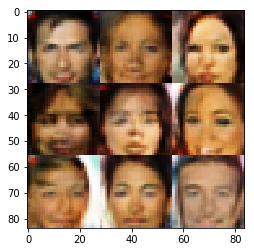

Epoch 1/1... Step 4220 Discriminator Loss: 1.5294... Generator Loss: 0.6468
Epoch 1/1... Step 4240 Discriminator Loss: 1.5345... Generator Loss: 0.6789
Epoch 1/1... Step 4260 Discriminator Loss: 1.5462... Generator Loss: 0.6575
Epoch 1/1... Step 4280 Discriminator Loss: 1.5255... Generator Loss: 0.7308
Epoch 1/1... Step 4300 Discriminator Loss: 1.4711... Generator Loss: 0.6965


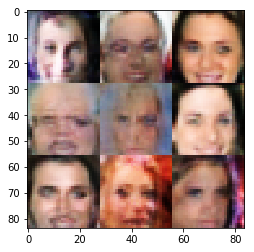

Epoch 1/1... Step 4320 Discriminator Loss: 1.6353... Generator Loss: 0.6393
Epoch 1/1... Step 4340 Discriminator Loss: 1.5981... Generator Loss: 0.5862
Epoch 1/1... Step 4360 Discriminator Loss: 1.4340... Generator Loss: 0.7636
Epoch 1/1... Step 4380 Discriminator Loss: 1.4706... Generator Loss: 0.7001
Epoch 1/1... Step 4400 Discriminator Loss: 1.5228... Generator Loss: 0.6381


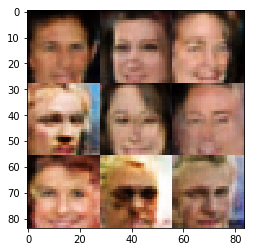

Epoch 1/1... Step 4420 Discriminator Loss: 1.4801... Generator Loss: 0.6743
Epoch 1/1... Step 4440 Discriminator Loss: 1.5905... Generator Loss: 0.6183
Epoch 1/1... Step 4460 Discriminator Loss: 1.5382... Generator Loss: 0.6262
Epoch 1/1... Step 4480 Discriminator Loss: 1.5648... Generator Loss: 0.6554
Epoch 1/1... Step 4500 Discriminator Loss: 1.4951... Generator Loss: 0.6956


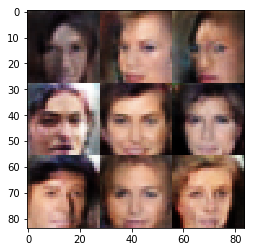

Epoch 1/1... Step 4520 Discriminator Loss: 1.4061... Generator Loss: 0.7039
Epoch 1/1... Step 4540 Discriminator Loss: 1.4812... Generator Loss: 0.7368
Epoch 1/1... Step 4560 Discriminator Loss: 1.4574... Generator Loss: 0.7236
Epoch 1/1... Step 4580 Discriminator Loss: 1.5082... Generator Loss: 0.6659
Epoch 1/1... Step 4600 Discriminator Loss: 1.4492... Generator Loss: 0.6570


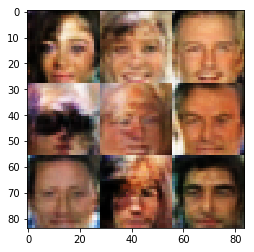

Epoch 1/1... Step 4620 Discriminator Loss: 1.5580... Generator Loss: 0.6205
Epoch 1/1... Step 4640 Discriminator Loss: 1.4883... Generator Loss: 0.6941
Epoch 1/1... Step 4660 Discriminator Loss: 1.4749... Generator Loss: 0.6921
Epoch 1/1... Step 4680 Discriminator Loss: 1.4859... Generator Loss: 0.6788
Epoch 1/1... Step 4700 Discriminator Loss: 1.4392... Generator Loss: 0.7456


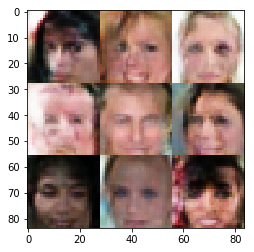

Epoch 1/1... Step 4720 Discriminator Loss: 1.5369... Generator Loss: 0.6622
Epoch 1/1... Step 4740 Discriminator Loss: 1.5000... Generator Loss: 0.6622
Epoch 1/1... Step 4760 Discriminator Loss: 1.4477... Generator Loss: 0.6608
Epoch 1/1... Step 4780 Discriminator Loss: 1.5067... Generator Loss: 0.6556
Epoch 1/1... Step 4800 Discriminator Loss: 1.4388... Generator Loss: 0.6958


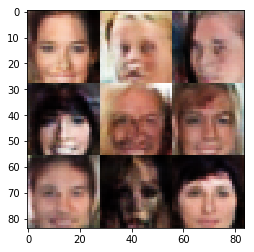

Epoch 1/1... Step 4820 Discriminator Loss: 1.4887... Generator Loss: 0.6849
Epoch 1/1... Step 4840 Discriminator Loss: 1.4122... Generator Loss: 0.7544
Epoch 1/1... Step 4860 Discriminator Loss: 1.5848... Generator Loss: 0.6659
Epoch 1/1... Step 4880 Discriminator Loss: 1.5375... Generator Loss: 0.5916
Epoch 1/1... Step 4900 Discriminator Loss: 1.5001... Generator Loss: 0.6558


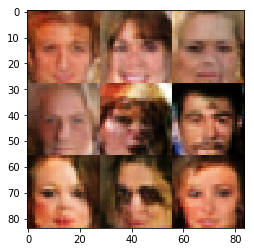

Epoch 1/1... Step 4920 Discriminator Loss: 1.3872... Generator Loss: 0.7419
Epoch 1/1... Step 4940 Discriminator Loss: 1.5065... Generator Loss: 0.7440
Epoch 1/1... Step 4960 Discriminator Loss: 1.5462... Generator Loss: 0.6666
Epoch 1/1... Step 4980 Discriminator Loss: 1.4782... Generator Loss: 0.6113
Epoch 1/1... Step 5000 Discriminator Loss: 1.4279... Generator Loss: 0.7411


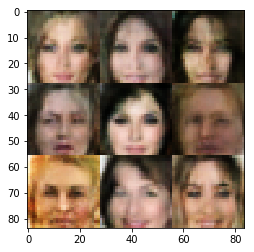

Epoch 1/1... Step 5020 Discriminator Loss: 1.5248... Generator Loss: 0.7147
Epoch 1/1... Step 5040 Discriminator Loss: 1.5259... Generator Loss: 0.7191
Epoch 1/1... Step 5060 Discriminator Loss: 1.4259... Generator Loss: 0.7296
Epoch 1/1... Step 5080 Discriminator Loss: 1.4914... Generator Loss: 0.6690
Epoch 1/1... Step 5100 Discriminator Loss: 1.5007... Generator Loss: 0.6018


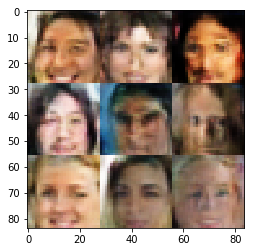

Epoch 1/1... Step 5120 Discriminator Loss: 1.6811... Generator Loss: 0.5774
Epoch 1/1... Step 5140 Discriminator Loss: 1.4555... Generator Loss: 0.7179
Epoch 1/1... Step 5160 Discriminator Loss: 1.4758... Generator Loss: 0.6192
Epoch 1/1... Step 5180 Discriminator Loss: 1.5299... Generator Loss: 0.6558
Epoch 1/1... Step 5200 Discriminator Loss: 1.4606... Generator Loss: 0.7177


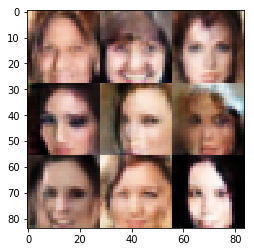

Epoch 1/1... Step 5220 Discriminator Loss: 1.4197... Generator Loss: 0.7196
Epoch 1/1... Step 5240 Discriminator Loss: 1.6131... Generator Loss: 0.5498
Epoch 1/1... Step 5260 Discriminator Loss: 1.5273... Generator Loss: 0.6575
Epoch 1/1... Step 5280 Discriminator Loss: 1.4441... Generator Loss: 0.7285
Epoch 1/1... Step 5300 Discriminator Loss: 1.5396... Generator Loss: 0.7035


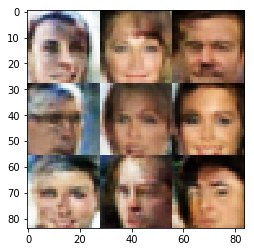

Epoch 1/1... Step 5320 Discriminator Loss: 1.3922... Generator Loss: 0.6961
Epoch 1/1... Step 5340 Discriminator Loss: 1.4615... Generator Loss: 0.6194
Epoch 1/1... Step 5360 Discriminator Loss: 1.4877... Generator Loss: 0.6650
Epoch 1/1... Step 5380 Discriminator Loss: 1.4842... Generator Loss: 0.7499
Epoch 1/1... Step 5400 Discriminator Loss: 1.4035... Generator Loss: 0.6778


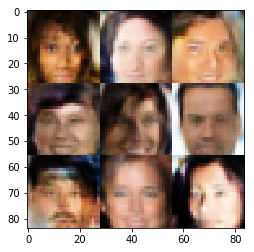

Epoch 1/1... Step 5420 Discriminator Loss: 1.5226... Generator Loss: 0.6369
Epoch 1/1... Step 5440 Discriminator Loss: 1.4447... Generator Loss: 0.6985
Epoch 1/1... Step 5460 Discriminator Loss: 1.5047... Generator Loss: 0.6744
Epoch 1/1... Step 5480 Discriminator Loss: 1.3899... Generator Loss: 0.6897
Epoch 1/1... Step 5500 Discriminator Loss: 1.4632... Generator Loss: 0.6965


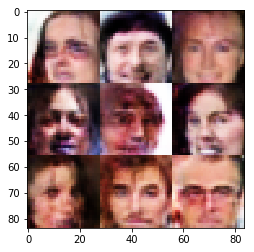

Epoch 1/1... Step 5520 Discriminator Loss: 1.5011... Generator Loss: 0.6809
Epoch 1/1... Step 5540 Discriminator Loss: 1.4769... Generator Loss: 0.6638
Epoch 1/1... Step 5560 Discriminator Loss: 1.4331... Generator Loss: 0.6962
Epoch 1/1... Step 5580 Discriminator Loss: 1.5443... Generator Loss: 0.6600
Epoch 1/1... Step 5600 Discriminator Loss: 1.5062... Generator Loss: 0.7439


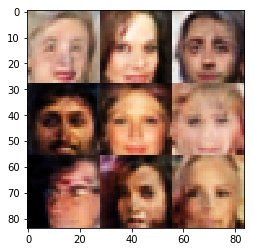

Epoch 1/1... Step 5620 Discriminator Loss: 1.4234... Generator Loss: 0.6967
Epoch 1/1... Step 5640 Discriminator Loss: 1.5645... Generator Loss: 0.6653
Epoch 1/1... Step 5660 Discriminator Loss: 1.5757... Generator Loss: 0.5883
Epoch 1/1... Step 5680 Discriminator Loss: 1.4061... Generator Loss: 0.6560
Epoch 1/1... Step 5700 Discriminator Loss: 1.4590... Generator Loss: 0.7076


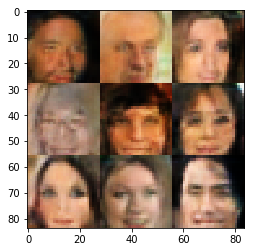

Epoch 1/1... Step 5720 Discriminator Loss: 1.5139... Generator Loss: 0.6033
Epoch 1/1... Step 5740 Discriminator Loss: 1.6367... Generator Loss: 0.5837
Epoch 1/1... Step 5760 Discriminator Loss: 1.4652... Generator Loss: 0.6537
Epoch 1/1... Step 5780 Discriminator Loss: 1.4151... Generator Loss: 0.6933
Epoch 1/1... Step 5800 Discriminator Loss: 1.5135... Generator Loss: 0.7138


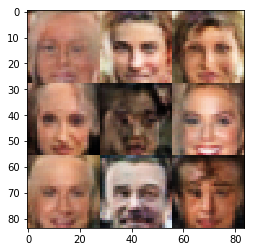

Epoch 1/1... Step 5820 Discriminator Loss: 1.5332... Generator Loss: 0.6271
Epoch 1/1... Step 5840 Discriminator Loss: 1.4634... Generator Loss: 0.6885
Epoch 1/1... Step 5860 Discriminator Loss: 1.4926... Generator Loss: 0.6983
Epoch 1/1... Step 5880 Discriminator Loss: 1.5226... Generator Loss: 0.6345
Epoch 1/1... Step 5900 Discriminator Loss: 1.6297... Generator Loss: 0.5952


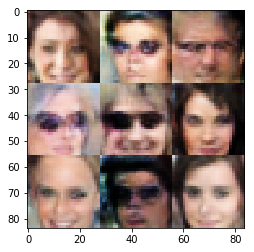

Epoch 1/1... Step 5920 Discriminator Loss: 1.6252... Generator Loss: 0.5218
Epoch 1/1... Step 5940 Discriminator Loss: 1.5576... Generator Loss: 0.5410
Epoch 1/1... Step 5960 Discriminator Loss: 1.4321... Generator Loss: 0.7410
Epoch 1/1... Step 5980 Discriminator Loss: 1.5376... Generator Loss: 0.5950
Epoch 1/1... Step 6000 Discriminator Loss: 1.5757... Generator Loss: 0.6174


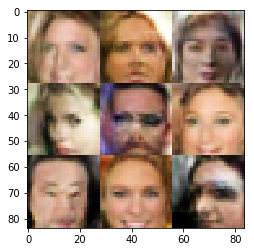

Epoch 1/1... Step 6020 Discriminator Loss: 1.4584... Generator Loss: 0.6632
Epoch 1/1... Step 6040 Discriminator Loss: 1.5571... Generator Loss: 0.6215
Epoch 1/1... Step 6060 Discriminator Loss: 1.3435... Generator Loss: 0.7139
Epoch 1/1... Step 6080 Discriminator Loss: 1.5820... Generator Loss: 0.6108
Epoch 1/1... Step 6100 Discriminator Loss: 1.4760... Generator Loss: 0.6939


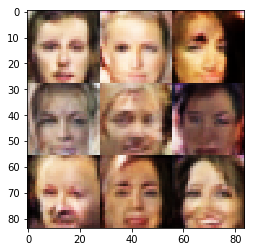

Epoch 1/1... Step 6120 Discriminator Loss: 1.6247... Generator Loss: 0.5935
Epoch 1/1... Step 6140 Discriminator Loss: 1.4825... Generator Loss: 0.6375
Epoch 1/1... Step 6160 Discriminator Loss: 1.4883... Generator Loss: 0.6957
Epoch 1/1... Step 6180 Discriminator Loss: 1.4578... Generator Loss: 0.6194
Epoch 1/1... Step 6200 Discriminator Loss: 1.4426... Generator Loss: 0.6800


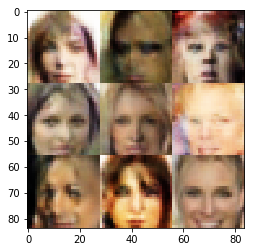

Epoch 1/1... Step 6220 Discriminator Loss: 1.5819... Generator Loss: 0.5900
Epoch 1/1... Step 6240 Discriminator Loss: 1.3736... Generator Loss: 0.7512
Epoch 1/1... Step 6260 Discriminator Loss: 1.4952... Generator Loss: 0.6623
Epoch 1/1... Step 6280 Discriminator Loss: 1.4945... Generator Loss: 0.6223
Epoch 1/1... Step 6300 Discriminator Loss: 1.4093... Generator Loss: 0.8813


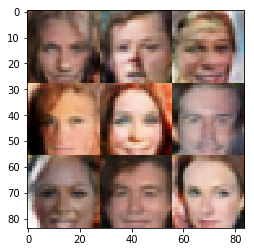

Epoch 1/1... Step 6320 Discriminator Loss: 1.6282... Generator Loss: 0.5952
Training Complete


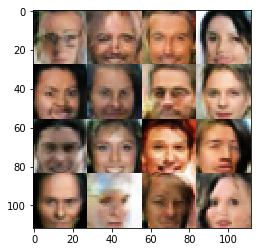

In [31]:
batch_size = 32 # see slack #project-5
z_dim = 100
learning_rate = 0.0002
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.